# [Sequence To Sequence](https://wikidocs.net/24996)

seq2seq는 번역기에서 대표적으로 사용되는 모델입니다.

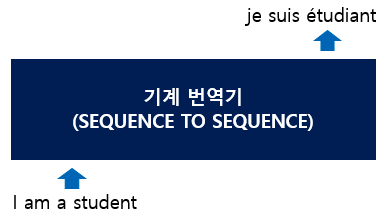

## Encoder
1. 인코더의 은닉 상태를 적절한 값(ex. 영벡터)으로 초기화한다.
2. 매 시점(time step)원문의 단어(token)가 입력되면(단어의 임베딩이 입력되면) 인코더는 이를 이용해 은닉 상태를 업데이트를 한다.
3. 입력 시퀀스의 끝까지 이 과정을 반복하면 인코더의 최종 은닉 상태는 입력 시퀀스의 정보를 압축 요약한 정보를 담고 있게 된다.
4. 이 마지막 시점에서의 인코더 은닉 상태를 컨텍스트 벡터라고 하고, 이 값은 디코더로 넘어간다.

## Decoder
1. 디코더는 전달받은 컨텍스트 벡터로 자신의 은닉 상태를 초기화한다.
2. 그리고 매 시점 자신이 바로 직전 시점에 출력했던 단어를 입력으로 받아, 자신의 은닉 상태를 업데이트하고, 이를 이용해 다음 단어를 예측한다. (최초 시점에서는 시퀀스 시작을 의미하는 `<sos>` 토큰(Start Of Sequence)을 입력으로 받는다.)
3. 이 과정을 정해진 반복 횟수 또는 시퀀스 끝을 나타내는 `<eos>` 토큰(End Of Sequence)이 나올 때까지 수행한다.

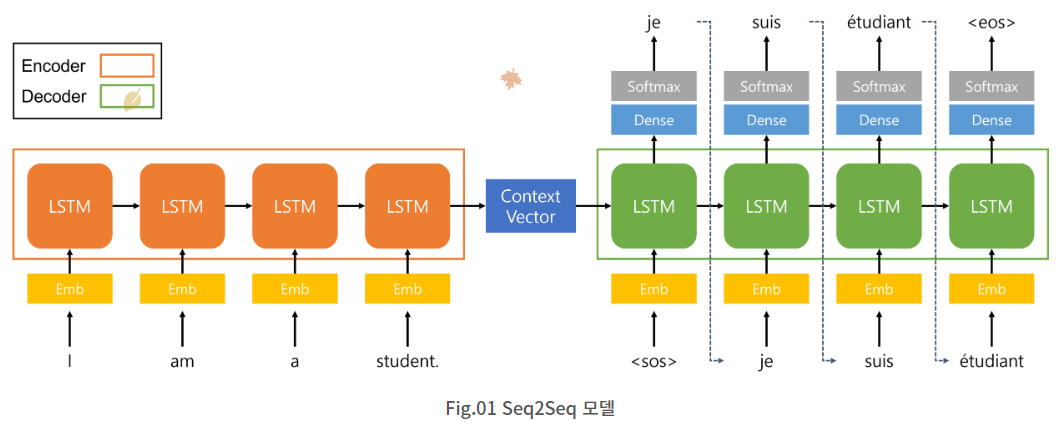

# 구현

In [3]:
import numpy as np
import torch
import torch.nn as nn

In [4]:
n_step = 5 # 글자의 최대 길이# input data, 가지고 있는 숫자의 가장 긴거의 값(queen)
n_hidden = 128 #

## 데이터

### 데이터 생성

In [5]:
seq_data = [['man', 'women'], ['black', 'white'], ['king', 'queen'], ['girl', 'boy'], ['up', 'down'], ['high', 'low']] # 서로 반대되는것을 예측하기위해 씀
np.array(seq_data).shape

(6, 2)

In [6]:
batch_size = len(seq_data) # 전체 데이터 크기 (6,2) 6개의 행에 1개의 행에 2개의 데이터
batch_size

6

### 데이터 토큰화

In [7]:
char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz'] # S(시작), E(끝), P(패딩)  # 토큰화하면 사전화 해야함
len(char_arr) # 대문자는 스페셜 토큰으로 사용하겠다는 의미, 그래서 값이 들어오면 소문자로 바꿔줘야함.
# 쳇 지피티도 어휘집이 있다..
# decoder에서 시작과 끝을 알수 없으니 강제로 알려준다.

29

### 데이터 사전

In [8]:
num_dic = {n: i for i, n in enumerate(char_arr)}
n_class = len(num_dic) # 사전의 크기를 알려줌
print(num_dic)
print(n_class)

{'S': 0, 'E': 1, 'P': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}
29


In [9]:
char_arr[5], num_dic['c']

('c', 5)

## 학습 데이터

### 학습 데이터 생성

In [11]:
seq_data

[['man', 'women'],
 ['black', 'white'],
 ['king', 'queen'],
 ['girl', 'boy'],
 ['up', 'down'],
 ['high', 'low']]

In [10]:
def make_batch():
    input_batch, output_batch, target_batch = [], [], [] # 총 3개의 초기 값,
    # input_batch encoder
    # output_batch decoder
    # target_batch 예측할때 사용


    for seq in seq_data: # seq_data에서 리스트 [man,women]을 seq 로 가져옴
        for i in range(2): # seq 는 리스트에 2개의 데이터가 있어 길이가 2임
            seq[i] = seq[i] + 'P' * (n_step - len(seq[i])) # P(2): 패딩 # 모든 길이가 같지 않기 때문에 padding을 넣어 값들의 길이들을 맞춰줌

        input = [num_dic[n] for n in seq[0]] # 문자를 넣으면 숫자로 나오게 함  n은 문자  input
        output = [num_dic[n] for n in ('S' + seq[1])] # S(0): 시작
        target = [num_dic[n] for n in (seq[1] + 'E')] # E(1): 끝

        input_batch.append(np.eye(n_class)[input]) # one-hot
        output_batch.append(np.eye(n_class)[output]) # one-hot
        target_batch.append(target) # not one-hot

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)


In [ ]:
예측
#   input->encoder   output->decoder
#  [['man',         'women']< 여기에서 시작을 알려주는 S 를 알려줘서 초기값을 아무값을 넣어 정답을 학습하는게 아니라 다음값을 예측할수 있게 해줌
#  ['black',        'white']
#  ['king',         'queen']
#  ['girl',          'boy']
#   ['up',          'down']
#   ['high',        'low']]
# target-> 값을 예측할때
# ['women']
# ['white']
# ['queen']
# ['boy']
# 'down']
# ['low']
# [ E ] -> 예측 다하고 나서 스페셜 토큰 E를넣어서 예측을 종료하게끔 알려준다.


In [ ]:
input_batch, output_batch, target_batch = make_batch()
# input_batch: (batch_size(데이터 수), input_size(최대 글자 수)=max 단어의 길이, embedding_size(원핫인코딩 수))
# output_batch: (batch_size(데이터 수), input_size(1(S) + 최대 글자 수)+start값이 들어감, embedding_size(원핫인코딩 수))
# target_batch: ((batch_size(데이터 수), input_size(1(S) + 최대 글자 수)+end 값이 들어감,embedding을 할필요 없음)
input_batch.shape, output_batch.shape, target_batch.shape

<ipython-input-16-2b8e91a0a80e>:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)


(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

#  Seq2Seq 모델 **생성**

### 디버깅

In [33]:
seq_data

[['manPP', 'women'],
 ['black', 'white'],
 ['kingP', 'queen'],
 ['girlP', 'boyPP'],
 ['upPPP', 'downP'],
 ['highP', 'lowPP']]

In [34]:
# 1. 데이터 구조 파악 : 리스트1 , 리스트2
# 2. 리스트2에서 가장 큰 길이를 찾아서 새로운 리스트3에 담음
# 2-1. 리스트3: 리스트2에서 가장 큰 길이들이 모임
# 3. 리스트3에서 가장 큰 수 찾음
tmp = [ len(row[0]) if len(row[0]) > len(row[1]) else len(row[1]) for row in seq_data ]
tmp

[5, 5, 5, 5, 5, 5]

In [35]:
max(tmp)

5

In [36]:
n_step # 글자의 최대 길이

5

In [37]:
for seq in [['man', 'women']]:
    for i in range(2):
        seq[i] = seq[i] + 'P' * (n_step - len(seq[i])) # P(2): 패딩

    input = [num_dic[n] for n in seq[0]]
    output = [num_dic[n] for n in ('S' + seq[1])] # S(0): 시작
    target = [num_dic[n] for n in (seq[1] + 'E')] # E(1): 끝

    break

In [38]:
seq

['manPP', 'women']

In [39]:
input

[15, 3, 16, 2, 2]

In [40]:
output

[0, 25, 17, 15, 7, 16]

In [41]:
target

[25, 17, 15, 7, 16, 1]

In [42]:
len(np.eye(n_class)[input]) # 5개 글자!!!

5

In [43]:
np.eye(n_class)[input][0] # 글자별 원핫인코딩!!

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [44]:
class Seq2Seq(nn.Module):
    def __init__(self):
        super(Seq2Seq, self).__init__()

        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5) # 인코딩
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5) # 디코딩
        self.fc = nn.Linear(n_hidden, n_class)

    def forward(self, enc_input, enc_hidden, dec_input):
        enc_input = enc_input.transpose(0, 1) # enc_input: [max_len(=n_step, time step), batch_size, n_class]
        dec_input = dec_input.transpose(0, 1) # dec_input: [max_len(=n_step, time step), batch_size, n_class]

        # enc_states : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        _, enc_states = self.enc_cell(enc_input, enc_hidden)
        # outputs : [max_len+1(=6), batch_size, num_directions(=1) * n_hidden(=128)]
        outputs, _ = self.dec_cell(dec_input, enc_states)

        pred = self.fc(outputs) # pred : [max_len+1(=6), batch_size, n_class]
        return pred

### 디버깅

In [45]:
input_batch, output_batch, target_batch = make_batch()
# input_batch: (batch_size(데이터 수), input_size(최대 글자 수), embedding_size(원핫인코딩 수))
# output_batch: (batch_size(데이터 수), input_size(1(S) + 최대 글자 수), embedding_size(원핫인코딩 수))
# target_batch: ((batch_size(데이터 수), input_size(1(E) + 최대 글자 수))
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

In [46]:
n_class, n_hidden

(29, 128)

In [47]:
enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
fc = nn.Linear(n_hidden, n_class)

In [48]:
enc_input = input_batch.transpose(0, 1)
# enc_input: (input_size(최대 글자 수), batch_size(데이터 수), embedding_size(원핫인코딩 수))
enc_input.shape

torch.Size([5, 6, 29])

In [49]:
dec_input = output_batch.transpose(0, 1)
# dec_input: (input_size(1(S) + 최대 글자 수), batch_size(데이터 수), embedding_size(원핫인코딩 수))
dec_input.shape

torch.Size([6, 6, 29])

In [50]:
enc_hidden = torch.zeros(1, batch_size, n_hidden) # 초기값
enc_hidden.shape

torch.Size([1, 6, 128])

In [51]:
_, enc_states = enc_cell(enc_input, enc_hidden)
_.shape, enc_states.shape # enc_states (layer_size * num_directions, batch_size, n_hidden)

(torch.Size([5, 6, 128]), torch.Size([1, 6, 128]))

In [52]:
outputs, _ = dec_cell(dec_input, enc_states)
outputs.shape, _.shape # outputs (input_size(1(E) + 최대 글자 수), batch_size, n_hidden)

(torch.Size([6, 6, 128]), torch.Size([1, 6, 128]))

In [53]:
pred = fc(outputs)
pred.shape # outputs (input_size(1(E) + 최대 글자 수), batch_size, embedding_size)

torch.Size([6, 6, 29])

## 학습

In [67]:
model = Seq2Seq()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

input_batch, output_batch, target_batch = make_batch()

In [68]:
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([6, 5, 29]), torch.Size([6, 6, 29]), torch.Size([6, 6]))

In [69]:
for epoch in range(5000):
    # make hidden shape [num_layers * num_directions, batch_size, n_hidden]
    hidden = torch.zeros(1, batch_size, n_hidden)
    # input_batch : [batch_size, max_len(=n_step, time step), n_class]
    # output_batch : [batch_size, max_len+1(=n_step, time step) (becase of 'S' or 'E'), n_class]
    # target_batch : [batch_size, max_len+1(=n_step, time step)], not one-hot
    output = model(input_batch, hidden, output_batch)
    # output : [max_len+1, batch_size, n_class]
    output = output.transpose(0, 1) # [batch_size, max_len+1(=6), n_class]
    loss = 0
    for i in range(0, len(target_batch)):
        # output[i] : [batch_size[i], max_len+1(=6), n_class]
        # target_batch[i] : [batch_size[i], max_len+1(=6)]

        # print(f'output: {output[i].shape}')
        # print(f'target_batch: {target_batch[i].shape}')
        # break
        loss += criterion(output[i], target_batch[i])
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 0.003288
Epoch: 2000 cost = 0.000889


KeyboardInterrupt: ignored

## 테스트

In [ ]:
def make_testbatch(input_word):
    input_batch, output_batch = [], []

    input_w = input_word + 'P' * (n_step - len(input_word)) # P: 패딩 추가
    input = [num_dic[n] for n in input_w]
    output = [num_dic[n] for n in 'S' + 'P' * n_step] # S와 P로 output 구성

    input_batch = np.eye(n_class)[input]
    output_batch = np.eye(n_class)[output]

    return torch.FloatTensor(input_batch).unsqueeze(0), torch.FloatTensor(output_batch).unsqueeze(0)

In [ ]:
input_batch, output_batch = make_testbatch('upp')
input_batch.shape, output_batch.shape

In [ ]:
hidden = torch.zeros(1, 1, n_hidden)
hidden.shape

In [ ]:
output = model(input_batch, hidden, output_batch)
output.shape

In [ ]:
output[0][0] # max: 16.0384

In [ ]:
output.data.max(2, keepdim=True) # values: 최대값, indices: 인덱스값

In [ ]:
predict = output.data.max(2, keepdim=True)[1]
predict.shape

In [ ]:
decoded = [char_arr[i] for i in predict]
decoded # E: 문장의 끝을 나타냄, P: 패딩

In [ ]:
# Test
def translate(word):
    input_batch, output_batch = make_testbatch(word)

    # make hidden shape [num_layers * num_directions, batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)
    output = model(input_batch, hidden, output_batch)
    # output : [max_len+1(=6), batch_size(=1), n_class]

    predict = output.data.max(2, keepdim=True)[1] # select n_class dimension
    decoded = [char_arr[i] for i in predict]
    end = decoded.index('E')
    translated = ''.join(decoded[:end])

    return translated.replace('P', '')

In [ ]:
print('test')
print('man ->', translate('man'))
print('mans ->', translate('mans'))
print('king ->', translate('king'))
print('black ->', translate('black'))
print('upp ->', translate('upp'))